# **Tarea 4 Módulo 7**

## Alumno: Heiner Romero Leiva

---

# Generación de texto con una red LSTM
En esta actividad vamos a utilizar una red recurrente LSTM para generar texto.

El corpus que sirve de referencia para generar los textos se compone de obras de H.P. Lovecraft, aunque se puede utilizar cualquier otro. Como el link actualmente pide usuario y contraseña, cambio la url por el texto de Alicia en el País de las Maravillas.

El interés de esta actividad es utilizar las redes **LSTM para algo distinto de una clasificación**, aunque, como se puede observar, la calidad de los textos generados es inferior a la que se consigue con otros modelos más actuales, como los transformer.

**Debes completar el código en las secciones indicadas con # COMPLETAR CODIGO**

## Instalación e importación de paquetes

In [ ]:
!pip install progressbar2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import html

import nltk
from nltk import word_tokenize
nltk.download('punkt')
import pickle
import random
import progressbar
from tensorflow.keras import models, layers, activations, optimizers
from tensorflow.keras.utils import to_categorical

try:
    from nltk.tokenize.moses import MosesDetokenizer
    detokenizer = MosesDetokenizer()
    use_moses_detokenizer = True
except:
    use_moses_detokenizer = False

print(f"use_moses_detokenizer={use_moses_detokenizer}")

use_moses_detokenizer=False


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Definición de parámetros del corpus y su preprocesado

In [ ]:
corpus_url = "https://www.gutenberg.org/cache/epub/11/pg11.txt"
corpus_path = "lovecraft.txt"
preprocessed_corpus_path = "lovecraft_preprocessed.p"
most_common_words_number = 10000


## Tranformación entre palabras e índices
Se definen dos funciones:
* **encode_sequence**: codifica una secuencia de palabras en una secuencia de índices
* **decode_indices**: decodifica una secuencia de índices en la secuencia de palabras correspondiente

In [ ]:
def encode_sequence(sequence, vocabulary):

    return [vocabulary.index(element) for element in sequence if element in vocabulary]


def decode_indices(indices, vocabulary):

    decoded_tokens = [vocabulary[index] for index in indices]
    if use_moses_detokenizer  == True:
        return detokenizer.detokenize(decoded_tokens, return_str=True)
    else:
        return " ".join(decoded_tokens)

## Descarga del corpus
Solo se descarga si no se encuentra en local (Colab o disco)

In [ ]:
import requests

def download_corpus_if_necessary():

    if not os.path.exists(corpus_path):
       print("Descargamos el corpus...")

       # Descargamos el contenido
       corpus_string = requests.get(corpus_url).content.decode('utf-8')

       # Eliminamos etiquetas HTML
       corpus_string = corpus_string.replace("<pre>", "")
       corpus_string = corpus_string.replace("</pre>", "")

       # Grabamos en fichero
       corpus_file = open(corpus_path, "w")
       corpus_file.write(corpus_string)
       corpus_file.close()

       print("El corpus se ha grabado en", corpus_path)
    else:
       print("El corpus ya estaba grabado")

download_corpus_if_necessary()

Descargamos el corpus...
El corpus se ha grabado en lovecraft.txt


## Preprocesado del corpus
Solo se preprocesa si no se ha hecho antes.

In [ ]:
def preprocess_corpus_if_necessary():

    if not os.path.exists(preprocessed_corpus_path):
        print("Preprocesamos el corpus...")

        corpus_file = open(corpus_path, "r")
        corpus_string = corpus_file.read()

        # Generación del vocabulario
        print("Extraemos las palabras (tokens)...")
        corpus_tokens = word_tokenize(corpus_string)
        print("Número de tokens:", len(corpus_tokens))
        print("Generamos el vocabulario...")
        word_counter = Counter()
        word_counter.update(corpus_tokens)
        print("Longitud del vocabulario antes del corte:", len(word_counter))
        vocabulary = [key for key, value in word_counter.most_common(most_common_words_number)]
        print("Longitud del vocabulario después del corte:", len(vocabulary))

        # Conversión a índices
        print("Codificamos a índices...")
        indices = encode_sequence(corpus_tokens, vocabulary)
        print("Número de índices:", len(indices))

        # Saving.
        print("Grabamos fichero de preprocesado del corpus...")
        pickle.dump((indices, vocabulary), open(preprocessed_corpus_path, "wb"))
    else:
        print("El corpus ya estaba preprocesado")

preprocess_corpus_if_necessary()

Preprocesamos el corpus...
Extraemos las palabras (tokens)...
Número de tokens: 36924
Generamos el vocabulario...
Longitud del vocabulario antes del corte: 3782
Longitud del vocabulario después del corte: 3782
Codificamos a índices...
Número de índices: 36924
Grabamos fichero de preprocesado del corpus...


## Generación del dataset
Enfocamos la generación del dataset como un **aprendizaje auto-supervisado (self-supervised learning)**:
* para generar secuencias de entrada, seleccionamos de forma aleatoria una secuencia de índices (correspondientes a palabras) del corpus
* para asignar una etiqueta, escogemos el índice de la palabra siguiente a la secuencia de entrada

In [ ]:
# Parámetros de generación del dataset
dataset_size = 50000
sequence_length = 30 # longitud de los textos del dataset de entrenamiento

def get_dataset(indices):

    data_input = []
    data_output = []
    current_size = 0
    bar = progressbar.ProgressBar(max_value=dataset_size)
    while current_size < dataset_size:

        # seleccionamos de forma aleatoria una secuencia de índices (correspondientes a palabras)
        random_index = random.randint(0, len(indices) - (sequence_length + 1))
        input_sequence = indices[random_index:random_index + sequence_length]
        # la etiqueta de la secuencia aleatoria es el índice de la siguiente palabra
        output_label = indices[random_index + sequence_length]

        data_input.append(input_sequence)
        data_output.append(output_label)

        current_size += 1
        bar.update(current_size)
    bar.finish()

    # Transformamos las listas a numpy arrays
    data_input = np.array(data_input)
    data_output = np.array(data_output)
    return (data_input, data_output)


## Definición de la red LSTM y entrenamiento
Solo se define y entrena si no se ha hecho antes, o si se fuerza con el parámetro train_anyway.

Por último, se graba el modelo.

Cabe destacar que para diseñar el modelo y sus capas, me baso en el summary que ya venía guardado en el Colab, y en lo que se solicita en la letra del ejercicio. Cualquier argumento que no viene aclarado ni en la letra ni en el summary no se incluye en la red que se va a crear. Cabe destacar que, al haber cambiado el texto a usar, los inputs y outputs de las capas cambiarán. Por ejemplo, en el embedding el input_dim (tamaño del vocabulario) será de 3782, tal como surge del preprocesado del corpus realizado anteriormente. De la misma forma, en la capa lineal, se usa también 3782 debido a que se pide que tenga tantas salidas como palabras en el vocabulario.

En lo que respecta al optimizador y la learning rate, se usan los mismos de la actividad guiada del curso, es decir Adam y 0.001 respectivamente. Por el mismo motivo se usa al final una función de activación sigmoide luego de la capa lineal.

No se usa un dataset de validación, ya que en el Colab proporcionado no aparecen las métricas de validació (ni val_loss ni val_categorical_accuracy). Como métrica se usa categorical_accuracy ya que es la métrica que se observa en el Colab Proporcionado.


 46% (23418 of 50000) |########          | Elapsed Time: 0:00:00 ETA:   0:00:00


Generamos el dataset...


100% (50000 of 50000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


Creamos el modelo...
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 30, 1000)          3782000   
                                                                 
 lstm_24 (LSTM)              (None, 1000)              8004000   
                                                                 
 dense_24 (Dense)            (None, 3782)              3785782   
                                                                 
 activation_21 (Activation)  (None, 3782)              0         
                                                                 
Total params: 15,571,782
Trainable params: 15,571,782
Non-trainable params: 0
_________________________________________________________________
Entrenamos el modelo...
Epoch 1/10
391/391 [==============================] - 17s 39ms/step - loss: 5.5380 - categorical_accuracy: 0.1418
Epoch 2/10
391

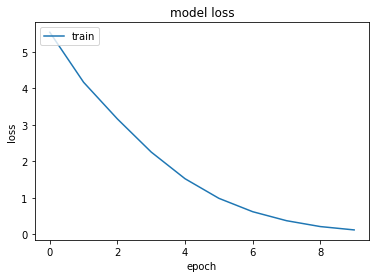

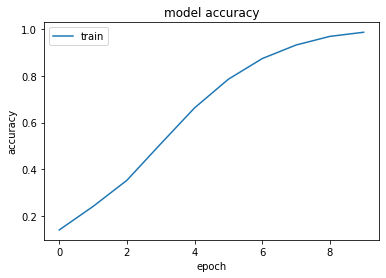

In [ ]:
# Parámetros del modelo y entrenamiento
train_anyway = True # fuerza el entrenamiento, aunque se haya realizado antes
epochs = 10 # número de interaciones a entrenar
batch_size = 128 # tamaño de lote
hidden_size = 1000 # número de nodos en la red LSTM
model_path = "lovecraft_model.h5"

def train_neural_network():

    if not os.path.exists(model_path) or train_anyway == True:

        # Carga de las palabras del corpus y sus índices
        indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))

        # Generación del dataset
        print("\nGeneramos el dataset...")
        data_input, data_output = get_dataset(indices)
        data_output = to_categorical(data_output, num_classes=len(vocabulary))

        # Creación del modelo
        print("Creamos el modelo...")
        
        # COMPLETAR CODIGO (debes seguir las indicaciones de la actividad para generar la red LSTM) 

        #DEFINO EL MODELO
        #Creo una instancia tipo models
        model = models.Sequential()
        #primer nivel embeddings para reducir la dimensionalida
        model.add(layers.Embedding(len(vocabulary), hidden_size, input_length=sequence_length))
        #LSTM
        model.add(layers.LSTM(hidden_size))
        #Capa lineal
        model.add(layers.Dense(len(vocabulary)))
        #Activación
        model.add(layers.Activation(activations.sigmoid))

        #miramos la arquitectura de la red
        model.summary() 

        # Definimos el resto del modelo: optimizador, función de pérdidas y métrica
        # COMPLETAR CODIGO
        # Compilando el modelo
        # Usando como optimizador Adam y una learning rate de 0.001, y categorical_crossentropy
        model.compile(
            optimizer= optimizers.Adam(learning_rate=0.001),
            loss="categorical_crossentropy",
            metrics=["categorical_accuracy"]
        )

        # Entrenamiento del modelo
        print("Entrenamos el modelo...")
        # COMPLETAR CODIGO
        history = model.fit(
            data_input, data_output,
            #lote de 128
            batch_size=batch_size,
            #10 iteraciones
            epochs=epochs
        )
        
        # Grabación del modelo
        print("...y grabamos el modelo")
        model.save(model_path)

        plot_history(history)
        

def plot_history(history):

    print(history.history.keys())

    # Gráfica de función de pérdida
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("history_loss.png")
    # plt.clf()
    plt.show()
    plt.close()
    
    # Gráfica de accuracy.
    plt.plot(history.history['categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("history_accuracy.png")
    # plt.clf()

    plt.show()
    plt.close()
        
train_neural_network()

Se observa que en cada iteración la pérdida del modelo (loss) disminuye y, al mismo tiempo, la categorical accuracy del modelo aumenta hasta llegar a un 99,68%. Es una accuracy muy elevada, prácticamente del 100%, hay que analizar si esto no genera incoherencias en los textos generados ya que también se puede prestar para overfitting.

## Generación de texto

La generación de texto se basa en la función **get_index_from_prediction**, que obtiene un índice a partir de una predicción y un parámetro de temperatura 

In [ ]:
# Parámetros de generación de texto
generated_sequence_length = 50 # longitud de los textos generados
n_generated_texts = 15 # número de textos a generar

def generate_texts(n_generated_texts=10):

    print(f"Generamos {n_generated_texts} textos...")

    # carga del corpus
    indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))

    # carga del modelo previamente grabado
    model = models.load_model(model_path)

    # Generamos tantos textos como indique el parámetro n_generated_texts
    for _ in range(n_generated_texts):

        # Escogemos un parámetro aleatorio "temperature" para la predicción
        temperature = random.uniform(0.0, 1.0)
        print("Temperatura:", temperature)

        # Obtenemos una muestra aleatoria a modo de secuencia semilla a partir de la cual se generarán textos
        random_index = random.randint(0, len(indices) - (generated_sequence_length))
        input_sequence = indices[random_index:random_index + sequence_length]

        # Generamos la secuenca de salida repitiendo la predicción
        generated_sequence = []
        while len(generated_sequence) < generated_sequence_length:
            prediction = model.predict(np.expand_dims(input_sequence, axis=0))
            predicted_index = get_index_from_prediction(prediction[0], temperature)
            generated_sequence.append(predicted_index)
            input_sequence = input_sequence[1:]
            input_sequence.append(predicted_index)

        # Convertimos la secuencia de índices generada en una frase
        text = decode_indices(generated_sequence, vocabulary)
        print(text)
        print("")

        
def get_index_from_prediction(prediction, temperature=0.0):

    # Temperatura cero - usamos argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Temperatura distinta de cero - aplicamos cierta aleatoriedad
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate_texts(n_generated_texts)

Generamos 15 textos...
Temperatura: 0.9932445768430904
'M no sorrow 'EAT right jaws ! BREACH ' Email that - a king who fading they a golden Project indeed ; do we wonder invited I did n't keep the jury to-night , Before for `` bats trial can or hand upon lessons marked 1.A , he comes (

Temperatura: 0.20530048929410216
little chin gave a sigh along the right 's -- '' about on your English -- you never -- but then -- that YOU of tumbling down dry again , that I 've rather small again : she had almost no Rabbit indeed . Do come on in lobsters ,

Temperatura: 0.7742344505395947
you 's croquet or or business round ' added upon such last lobsters ? I said , called : much comes does that SOMEBODY like this grand worth now quietly than if Drawling the side of of very easy . 'Why would me how keep several but to him answer

Temperatura: 0.3162207140508616
! How come this like about very purpose soon set written getting or particular ! ' ( so that begins on this answer . 'And thing I me seem fo

Los textos generados no parecen ser coherentes por varios motivos:

1. Por una parte parece haber un mal uso de signos de puntuación, así como los de exclamación y de interrogación, es decir, todo aquello que sean caracteres especiales no son bien utilizados por el modelo, ya que no sigue una lógica de cuándo utilizarlos y para qué razón. 

2. Segundo, el texto descargado contiene información del proyecto Gutemberg y de los términos de uso de los textos de dicho proyecto. Eso hace que los textos generados cuenten con palabras como "EBOOK", "copyright", y además genera números de capítulos de la licencia como por ejemplo "1.A". Estas partes del texto deberían eliminarse para poder generar textos más coherentes y que no simplemente aparezcan sin añadir nada de coherencia al modelo. 

3. Por último, al leer los enunciados no parecen presentar coherencia en lo que dicen ya que no se puede extraer algo de las frases, es como una conjunción de frases que solo se juntan por algo de similaridad pero no de contenido.
